In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import os
import h5py

from tta_agg_models import TTARegression, TTAPartialRegression, ImprovedLR, TTARegressionFrozen
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('1')

aug = 'flips'
full_lr_pth = './mnist/' + aug + '/agg_models/mnist_cnn/combo/full_lr.pth'
partial_lr_pth = './mnist/' + aug + '/agg_models/mnist_cnn/combo/partial_lr.pth'

n_augs = 3
n_classes = 10
scale =1
plr = TTAPartialRegression(n_augs,n_classes,scale,'even')
if os.path.exists(partial_lr_pth):
    plr.load_state_dict(torch.load(partial_lr_pth))
plr_coeffs = plr.coeffs.detach().numpy()

flr = TTARegression(n_augs,n_classes,scale,'even')
if os.path.exists(full_lr_pth):
    flr.load_state_dict(torch.load(full_lr_pth))
flr_coeffs = flr.coeffs.detach().numpy()
normalized_coeffs = flr_coeffs / np.sum(flr_coeffs, axis=0)

Using GPU:1


Text(0.5, 1.0, 'Augmentation Utility Varies by Class')

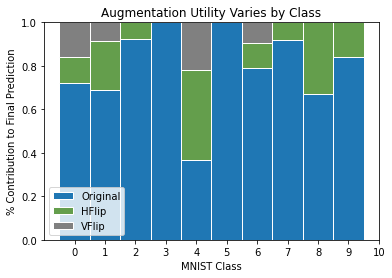

In [3]:
# make this a stacked bar chart
from matplotlib import rc
from colour import Color
barWidth = 1
n_classes = 10
r = np.arange(n_classes)
labels = ['Original', 'HFlip', 'VFlip']
red = Color("#1f77b4")
colors = list(red.range_to(Color("gray"),len(labels)))
plt.figure(figsize=(6, 4))
for i in range(n_augs):
    #plt.scatter(np.arange(n_classes), normalized_coeffs[i,:], label=labels[i])
    bottom = np.sum(normalized_coeffs[:i,:], axis=0)
    color = colors[i].get_hex()
    plt.bar(r, normalized_coeffs[i,:], bottom=bottom, color=color, edgecolor='white', width=barWidth, label=labels[i])

#plt.ylabel('Fractional Contribution to final prediction')
#plt.xlabel('MNIST Class')
plt.legend()
plt.xticks(np.arange(11))
plt.ylim(0, 1)
plt.ylabel('% Contribution to Final Prediction')
plt.xlabel('MNIST Class')
plt.title("Augmentation Utility Varies by Class")

In [4]:
normalized_coeffs.shape

(3, 10)

[]

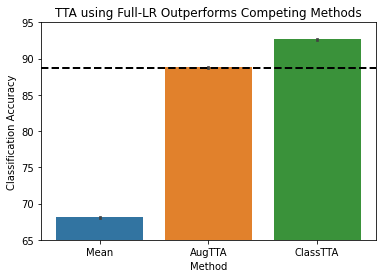

In [6]:
# draw line for original model prediction accuracy
# change names to 
results = pd.read_csv('./results/mnist/' + aug + '/val/mnist_cnn_agg_fs')
orig_acc = np.mean(results[results['aug'] == 'orig']['top1'])
other = results[results['aug'] == 'combo']
other = other[other['agg'].isin(['mean', 'partial_lr', 'full_lr'])]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='agg', y='top1', data=other)
plt.xticks(np.arange(3), ["Mean", "AugTTA", "ClassTTA"])
plt.ylim(65, 95)
plt.title("TTA using Full-LR Outperforms Competing Methods")
plt.ylabel("Classification Accuracy")
ax.axhline(orig_acc, ls='--', color='black', linewidth=2,)
plt.xlabel("Method")
plt.plot()

In [6]:
np.max(orig_acc['top1']), np.min(np.max(orig_acc['top1']))


IndexError: invalid index to scalar variable.

# Accuracy improvement on MNIST vs. % of training set

In [8]:
# Iterate over results for different cnns in the results folder
aug = 'flips'
model_pref = 'mnist_cnn'
pcts = [.005, .01, .02, .03, .04, .05, .10, .20, .50, .75, 1.00]
model_name_opts = [model_pref + '_' + str(opt) for opt in pcts]
results_dicts = []
n_runs = 5
for i, model_name in enumerate(model_name_opts):
    model_results = pd.read_csv('./results/mnist/' + aug + '/val/' + model_name + '_agg_fs')
    for j in range(n_runs):
        orig_acc = model_results[model_results['aug'] == 'orig']['top1'].iloc[j]
        mean_acc = model_results[model_results['agg'] == 'mean']['top1'].iloc[j]
        flr_acc = model_results[model_results['agg'] == 'full_lr']['top1'].iloc[j]
        plr_acc = model_results[model_results['agg'] == 'partial_lr']['top1'].iloc[j]
        pct = pcts[i]
        formatted_results = [{'top1': orig_acc, 'method': 'orig', 'pct': pct,'model_name': model_name, 'run': j},
                             {'top1': mean_acc,'method': 'mean', 'pct': pct,'model_name': model_name, 'run': j},
                             {'top1': flr_acc, 'method': 'full_lr','pct': pct,'model_name': model_name, 'run': j},
                             {'top1':plr_acc,'method': 'partial_lr','pct': pct,'model_name': model_name, 'run': j}]
        results_dicts.extend(formatted_results)
results = pd.DataFrame(results_dicts)
only_full_lr = results[results['method'].isin(['orig', 'full_lr'])]
only_full_lr['log_pct'] = np.log(only_full_lr['pct'])


/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


([<matplotlib.axis.XTick at 0x7f2015998190>,
 [Text(0, 0, '.5'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '20'),
  Text(0, 0, '50'),
  Text(0, 0, '100')])

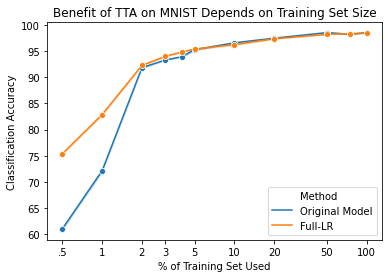

In [11]:
plt.figure(figsize=(6, 4))
sns.lineplot(x='log_pct', y='top1', hue='method', err_style='band', ci=95, data=only_full_lr, marker='o')
plt.title("Benefit of TTA on MNIST Depends on Training Set Size")
plt.xlabel("% of Training Set Used")
plt.ylabel("Classification Accuracy")
L=plt.legend()
L.get_texts()[0].set_text('Method')
L.get_texts()[1].set_text('Original Model')
L.get_texts()[2].set_text('Full-LR')
xtick_pos = sorted(list(set(only_full_lr['log_pct'])))
xtick_lab = sorted([x*100 for x in list(set(only_full_lr['pct']))])
xtick_lab = [".5", "1", "2", "3", "4", "5", "10", "20", "50", "75", "100"]
del xtick_pos[9]
del xtick_lab[9]
del xtick_pos[4]
del xtick_lab[4]
plt.xticks(xtick_pos, xtick_lab)

In [27]:
sorted(list(set(only_full_lr['log_pct']))), sorted(list(set(only_full_lr['pct'])))

([-5.298317366548036,
  -4.605170185988091,
  -3.912023005428146,
  -3.506557897319982,
  -3.2188758248682006,
  -2.995732273553991,
  -2.3025850929940455,
  -1.6094379124341003,
  -0.6931471805599453,
  -0.2876820724517809],
 [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 0.75])

In [14]:
hf = h5py.File('./mnist/flips/model_outputs/val/mnist_cnn_test.h5', 'r')

In [17]:
original = hf['batch1_inputs'][0]
hflip = hf['batch1_inputs'][1]
vflip = hf['batch1_inputs'][2]
labels = hf['batch1_labels'][:]

In [67]:
from scipy.special import softmax

digit = 5
idxs_4 = np.where(labels == digit)[0]
original_4 = softmax(original[idxs_4], axis=1)
hflip_4 = softmax(hflip[idxs_4], axis=1)
vflip_4 = softmax(vflip[idxs_4], axis=1)

original_4_preds = np.argmax(original_4, axis=1)
hflip_4_preds = np.argmax(hflip_4, axis=1)
vflip_4_preds = np.argmax(vflip_4, axis=1)

orig_acc = len((np.where(original_4_preds == 2)[0]))/len(idxs_4)
hflip_acc = len((np.where(hflip_4_preds == 2)[0]))/len(idxs_4)
vflip_acc = len((np.where(vflip_4_preds == 2)[0]))/len(idxs_4)

In [68]:
print(orig_acc, hflip_acc, vflip_acc)

0.0044943820224719105 0.3955056179775281 0.7842696629213484


(array([  6.,   6., 349.,   0.,   0.,  30.,   0.,  12.,   6.,  36.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

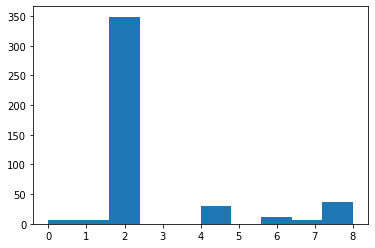

In [66]:
plt.hist(vflip_4_preds)